In [7]:
# !pip install dostoevsky
# !pip install wordcloud
# !pip install demoji
# !pip install sentence_transformers
# !pip install pymorphy2
# !pip install keras
# !pip install tensorflow

^C


In [286]:
import dostoevsky
import pandas as pd
import wordcloud
from tqdm import tqdm
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel
import re
import demoji
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import nltk
from pymystem3 import Mystem
import gensim
from nltk.corpus import stopwords
from collections import Counter
nltk.download('stopwords')
from tqdm import tqdm
from nltk import sent_tokenize, word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
nltk.download('punkt')
from string import punctuation
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.cluster import KMeans
import pymorphy2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from nltk.stem import SnowballStemmer
nltk.download('wordnet')
nltk.download('omw-1.4')
import keras
from spacy.lang.ru import Russian
from keras.layers import Input, Embedding
from nltk.stem import WordNetLemmatizer
import gensim.downloader as api

[nltk_data] Downloading package stopwords to C:\Users\ИТ
[nltk_data]     ОАРБ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\ИТ
[nltk_data]     ОАРБ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\ИТ
[nltk_data]     ОАРБ\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\ИТ
[nltk_data]     ОАРБ\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [287]:
def clean_text(txt):

    proccesed_txt = demoji.replace(txt, "")
    proccesed_txt = proccesed_txt.replace('ё', 'е')
    
    return proccesed_txt

In [288]:
def normalize_text(txt):

  global russian_stopwords
  global lemmatizer
  global spacy_rus

  proccesed_txt = re.sub('\[\w+\d+\|\w+\]', '', txt)

  doc = spacy_rus(proccesed_txt)
  proccesed_txt = ' '.join([token.text for token in doc if token.pos_ != 'PROPN'])
  proccesed_txt = proccesed_txt.lower()
  proccesed_txt = re.sub('[^а-я]', ' ', proccesed_txt)
  tokens = word_tokenize(proccesed_txt)

  tokens = [lemmatizer.parse(x)[0].normal_form for x in tokens if x not in russian_stopwords and \
                                                                                  x not in punctuation]
  proccesed_txt = " ".join(tokens)


  return proccesed_txt

In [289]:
tokenizer = RegexTokenizer()
FastTextSocialNetworkModel.MODEL_PATH = './fasttext-social-network-model.bin'
model = FastTextSocialNetworkModel(tokenizer=tokenizer)

def negative_comments(df):

  global model

  messages = df.Text.to_list()
  df['result'] = model.predict(messages, k=2)

  df['neutral'] = df['result'].apply(lambda x: x['neutral'] if 'neutral' in x.keys() else 0)
  df['negative'] = df['result'].apply(lambda x: x['negative'] if 'negative' in x.keys() else 0)
  df['speech'] = df['result'].apply(lambda x: x['speech'] if 'speech' in x.keys() else 0)
  df['skip'] = df['result'].apply(lambda x: x['skip'] if 'skip' in x.keys() else 0)
  df['positive'] = df['result'].apply(lambda x: x['positive'] if 'positive' in x.keys() else 0)
  df['n_words'] = df['Text'].apply(lambda x: len(x.split(' ')))

  df = df.query('negative > 0 & positive == 0 & n_words > 3')

  return df

In [290]:
%%time
russian_stopwords = set(stopwords.words('russian'))
lemmatizer =pymorphy2.MorphAnalyzer()
spacy_rus = Russian()

# data_com1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/vk_comments/all_comments.txt', sep='\n')
# data_com1 = data_com1.rename(columns={'Text':'original_text'})

# data_com2= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/vk_comments/vse_commen.txt', sep='\n', header=None)
# data_com2 = data_com2.rename(columns={0:'original_text'})

# data_com = pd.concat([data_com1, data_com2], ignore_index=True)
# data_com.drop_duplicates(inplace=True, ignore_index=True)

data_com = pd.read_excel('comments.xlsx')

data_com['Text'] = data_com['title'].apply(clean_text)
data_com = negative_comments(data_com)#.iloc[:2000] #2000
data_com['Text'] = data_com['Text'].apply(normalize_text)
data_com = data_com[data_com['Text'] != '']
data_com.reset_index(drop=True, inplace=True)

data_com

Wall time: 13 s


,id,title,comment,response,date,mark,status,Text,result,neutral,negative,speech,skip,positive,n_words
0,10704717,Отказываются возвращать часть комиссии за обсл...,"В один момент заблокировали все карты разом, п...",NaN,23.08.2022 16:19,1.0,Проверяется,отказываться возвращать часть комиссия обслужи...,"{'neutral': 0.9755869507789612, 'negative': 0....",0.975587,0.067557,0.0,0.0,0.0,13
1,10704641,Сбер заблокировал по 115 фз,"Здравствуйте, сегодня уже 4 месяца как меня за...",NaN,23.08.2022 14:13,1.0,Проверяется,сбер заблокировать фз,"{'neutral': 0.9591643214225769, 'negative': 0....",0.959164,0.090103,0.0,0.0,0.0,5
2,10704631,При внесение наличных произошёл сбой,https://i.ibb.co/qNn62tk/U3-Cnemlgns-M.jpg Дат...,NaN,23.08.2022 14:00,NaN,NaN,внесение наличный произойти сбой,"{'neutral': 0.9724247455596924, 'negative': 0....",0.972425,0.063725,0.0,0.0,0.0,5
3,10704524,"При внесении наличных произошёл сбой, не пришл...",Дата 22.08.22 Время 19:04:01Пополняя карту в э...,"Здравствуйте!Я выяснила, что операция внесения...",23.08.2022 11:02,2.0,Проверяется,внесение наличный произойти сбой прислать деньга,"{'neutral': 0.8991314172744751, 'negative': 0....",0.899131,0.268951,0.0,0.0,0.0,8
4,10704509,Навязывание дополнительных банковских продуктов,22.08.2022г. около 20 ч. вечера мне понадобило...,Спасибо за отзыв. Подождем ответ представителя...,23.08.2022 10:45,1.0,Проверяется,навязывание дополнительный банковский продукт,"{'neutral': 0.9893575310707092, 'negative': 0....",0.989358,0.129413,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3154,10460382,Неполное внесение денежных средств,28.12.2020 года я вносила средства через банко...,Добрый день! Простите🙏Я во всем разберусь.С ув...,31.12.2020 15:14,1.0,NaN,неполный внесение денежный средство,"{'neutral': 0.8519628047943115, 'negative': 0....",0.851963,0.212079,0.0,0.0,0.0,4
3155,10460371,Претензия по возврату средств,"Приветствую. 22.08 я, как обычно, оплатила усл...",Спасибо за отзыв. Давайте подождём окончательн...,31.12.2020 14:27,1.0,Не засчитана,претензия возврат средство,"{'neutral': 0.9149109721183777, 'negative': 0....",0.914911,0.196836,0.0,0.0,0.0,4
3156,10460306,Неизвестные переводы и безучастие службы безоп...,"К концу года проверила выписку по сбербанку, з...","Нам очень жаль, что вы попали в такую ситуацию...",31.12.2020 11:10,NaN,NaN,неизвестный перевод безучастие служба безопасн...,"{'neutral': 0.6150978803634644, 'negative': 0....",0.615098,0.377551,0.0,0.0,0.0,6
3157,10460266,Карту так и не получил,В начале ноября повелся на рекламу решил оформ...,Спасибо за отзыв. Давайте подождём окончательн...,31.12.2020 8:07,1.0,NaN,карта получить,"{'neutral': 0.9706977605819702, 'negative': 0....",0.970698,0.025967,0.0,0.0,0.0,5


In [291]:
tfidfvectoriser=TfidfVectorizer(max_features=300, min_df=3)
tfidfvectoriser.fit(data_com.Text)
tfidf_vectors=tfidfvectoriser.transform(data_com.Text)

tfidf_terms = tfidfvectoriser.get_feature_names_out()
idf = tfidfvectoriser.idf_
terms_dict = dict(zip(tfidf_terms, idf))
coefs = pd.DataFrame(data = tfidf_vectors.toarray(),columns = tfidf_terms)
tfidf_vectors.shape

(3159, 300)

In [292]:
model_w2v.most_similar('gdr_NOUN')

[('berkshire_NOUN', 0.8032865524291992),
 ('депозитарный::расписка_NOUN', 0.8018016815185547),
 ('cfds_NOUN', 0.7985637187957764),
 ('qiwi_NOUN', 0.7974023222923279),
 ('bluestone_NOUN', 0.7881304025650024),
 ('lloyds_NOUN', 0.7880775928497314),
 ('евросибэнерго_NOUN', 0.7845545411109924),
 ('dst_NOUN', 0.7842196822166443),
 ('potash_NOUN', 0.7841376066207886),
 ('securities_NOUN', 0.7834041714668274)]

In [293]:
for i in data_com.Text:
    for c in i.split(' '):
        if len(c) < 2:
            print('-'*125)
            print(c)

-----------------------------------------------------------------------------------------------------------------------------
г
-----------------------------------------------------------------------------------------------------------------------------
ю
-----------------------------------------------------------------------------------------------------------------------------
р
-----------------------------------------------------------------------------------------------------------------------------
ф
-----------------------------------------------------------------------------------------------------------------------------
я
-----------------------------------------------------------------------------------------------------------------------------
х
-----------------------------------------------------------------------------------------------------------------------------
к
--------------------------------------------------------------------------------------------------------

In [294]:
document_word_embeddings

array([[[ 4.81721573e-02,  6.51424602e-02,  7.80880079e-02, ...,
         -4.05451171e-02,  2.08073594e-02,  4.37039509e-02],
        [ 1.14125311e-01,  8.63324106e-02, -4.42978777e-02, ...,
          1.68381017e-02, -3.86954620e-02, -6.48214668e-02],
        [ 1.10872865e-01,  3.41087729e-02,  1.51840560e-02, ...,
         -1.11845527e-02, -1.20078221e-01, -3.31831747e-03],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.26405612e-03,  8.72852132e-02, -5.05161136e-02, ...,
          3.21830213e-02,  5.06813754e

In [295]:
model_w2v = api.load("word2vec-ruscorpora-300")
tokenizer=Tokenizer()
tokenizer.fit_on_texts(data_com.Text)

# c = []
# key_w2v = [a.split('_')[0] for a in model_w2v.__dict__['vocab'].keys()]
# ending_w2v = ['_NOUN', '_VERB', '_ADJ', '_ADV']
# for key in tokenizer.word_index.keys():
#   if len(key) < 2:
#     c.append(key)
# for k in c:
#   del tokenizer.word_index[k]
# p = 1
# for key in tokenizer.word_index.keys():
#   tokenizer.word_index[key] = p
#   p += 1

tokenized_documents=tokenizer.texts_to_sequences(data_com.Text)
tokenized_paded_documents=pad_sequences(tokenized_documents,maxlen=16,padding='post')

vocab_size=len(tokenizer.word_index)+1

embedding_matrix=np.zeros((vocab_size, 300))

ending_w2v = ['_NOUN', '_VERB', '_ADJ', '_ADV']
key_w2v = [a.split('_')[0] for a in model_w2v.__dict__['index_to_key']]
for word,i in tqdm(tokenizer.word_index.items()):
    if word in key_w2v:
      for c in ending_w2v:
        try:
          embedding_matrix[i]=model_w2v[word+c]
          break
        except:
          continue

# for word,i in tokenizer.word_index.items():
#     if word in model_w2v:
#         embedding_matrix[i]=model_w2v[word]

document_word_embeddings=np.zeros((len(tokenized_paded_documents),16,300))

for i in range(len(tokenized_paded_documents)):
    for j in range(len(tokenized_paded_documents[0])):
        document_word_embeddings[i][j]=embedding_matrix[tokenized_paded_documents[i][j]]

document_word_embeddings.shape

100%|█████████████████████████████████████████████████████████████████████████████| 2113/2113 [00:02<00:00, 894.24it/s]


(3159, 16, 300)

In [296]:
document_embeddings=np.zeros((len(tokenized_paded_documents),300))
words=tfidfvectoriser.get_feature_names()

for i in tqdm(range(len(document_word_embeddings))):
    for j in range(len(words)):

      document_embeddings[i]+=embedding_matrix[tokenizer.word_index[words[j]]].T*coefs.iloc[i][words[j]]

document_embeddings.shape

#pairwise_similarities=cosine_similarity(document_embeddings)
# pairwise_differences=euclidean_distances(document_embeddings)
# most_similar(0,pairwise_similarities,'Cosine Similarity')
# most_similar(0,pairwise_differences,'Euclidean Distance')

C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
100%|██████████████████████████████████████████████████████████████████████████████| 3159/3159 [01:36<00:00, 32.73it/s]


(3159, 300)

In [297]:
document_embeddings

array([[ 0.11610473,  0.00500617, -0.02139515, ..., -0.11339441,
        -0.07513967, -0.02898265],
       [ 0.06446283,  0.03681599, -0.13557489, ..., -0.04761851,
        -0.0476687 , -0.05783897],
       [ 0.05714814, -0.00614491, -0.07488644, ..., -0.05438494,
        -0.06181325, -0.06217826],
       ...,
       [-0.03393649,  0.09610169, -0.0758116 , ..., -0.00380766,
        -0.11037144, -0.13096552],
       [ 0.00316814, -0.0556033 , -0.04941703, ..., -0.00081753,
        -0.0500669 , -0.0901902 ],
       [ 0.08983577,  0.02532648, -0.06989266, ..., -0.03600323,
        -0.05175474,  0.04121631]])

In [298]:
pairwise_similarities=cosine_similarity(document_embeddings)

In [299]:
def most_similar(doc_id,similarity_matrix,matrix):
    print (f'Document: {data_com.iloc[doc_id]["Text"]}')
    print ('\n')
    print ('Similar Documents:')
    if matrix=='Cosine Similarity':
        similar_ix=np.argsort(similarity_matrix[doc_id])[::-1]
    elif matrix=='Euclidean Distance':
        similar_ix=np.argsort(similarity_matrix[doc_id])
    i = np.argmax(similar_ix)
    # for ix in similar_ix:
    #     if ix==doc_id:
    #         continue
    #     print('\n')
        
    print (f'Document: {data_com.iloc[i]["title"]}')

    print (f'{matrix} : {similarity_matrix[doc_id][i]}')

In [300]:
most_similar(50,pairwise_similarities,'Cosine Similarity')

Document: банк списывать комиссия уведомлять


Similar Documents:
Document: Быстро, не смотря на большое количество клиентов
Cosine Similarity : 0.3667453642695986


In [324]:
from sklearn.mixture import GaussianMixture
gm_bic= []
gm_score=[]
for i in range(2,40):
    gm = GaussianMixture(n_components=i,n_init=10,tol=1e-3,max_iter=1000).fit(document_embeddings)
    print("BIC for number of cluster(s) {}: {}".format(i,gm.bic(document_embeddings)))
    print("Log-likelihood score for number of cluster(s) {}: {}".format(i,gm.score(document_embeddings)))
    print("-"*100)
    gm_bic.append(-gm.bic(document_embeddings))
    gm_score.append(gm.score(document_embeddings))

BIC for number of cluster(s) 2: -5729041.051597541
Log-likelihood score for number of cluster(s) 2: 1022.7164120609767
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 3: -6159200.755053205
Log-likelihood score for number of cluster(s) 3: 1148.7696492187672
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 4: -6142335.923864767
Log-likelihood score for number of cluster(s) 4: 1204.068765666823
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 5: -6070793.454076958
Log-likelihood score for number of cluster(s) 5: 1250.7136183289704
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 6: -5962246.291662779
Log-likelihood score for number of cluster(s) 6: 1291.5014446178398
--

C:\Users\C43E~1\AppData\Local\Temp/ipykernel_8336/753153249.py:3: RuntimeWarning: invalid value encountered in log
  plt.scatter(x=[i for i in range(2,40)],y=np.log(gm_bic),s=150,edgecolor='k')


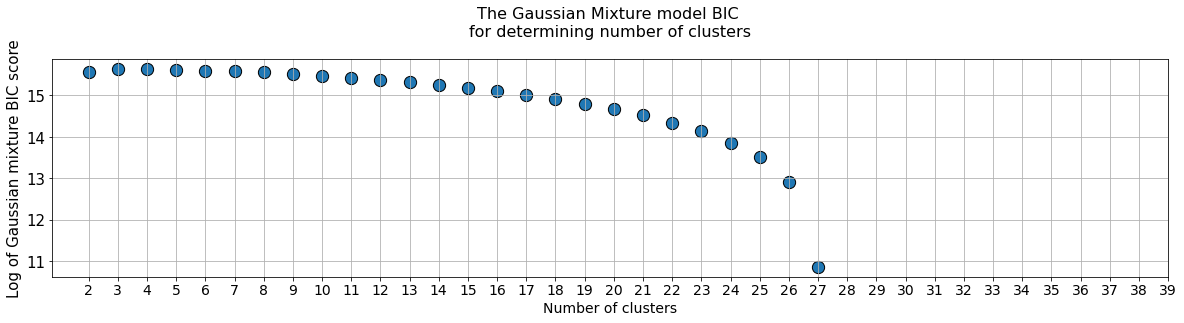

In [327]:
plt.figure(figsize=(20,4))
plt.title("The Gaussian Mixture model BIC \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,40)],y=np.log(gm_bic),s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Log of Gaussian mixture BIC score",fontsize=15)
plt.xticks([i for i in range(2,40)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

In [361]:
gm_score.index(max(gm_score))

37

In [363]:
gm_bic.index(min(gm_bic))

37

In [343]:
from sklearn.metrics import silhouette_score, davies_bouldin_score,v_measure_score
km_scores= []
km_silhouette = []
vmeasure_score =[]
db_score = []
for i in range(2,40):
    km = KMeans(n_clusters=i, random_state=0).fit(document_embeddings)
    preds = km.predict(document_embeddings)
    
    print("Score for number of cluster(s) {}: {}".format(i,km.score(document_embeddings)))
    km_scores.append(-km.score(document_embeddings))
    
    silhouette = silhouette_score(document_embeddings,preds)
    km_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
    
#     db = davies_bouldin_score(document_embeddings,preds)
#     db_score.append(db)
#     print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))
    print('-'*125)
#     v_measure = v_measure_score(y,preds)
#     vmeasure_score.append(v_measure)
#     print("V-measure score for number of cluster(s) {}: {}".format(i,v_measure))
#     print("-"*100)

Score for number of cluster(s) 2: -2071.137767048795
Silhouette score for number of cluster(s) 2: 0.07363353223626208
-----------------------------------------------------------------------------------------------------------------------------
Score for number of cluster(s) 3: -1987.1787477002074
Silhouette score for number of cluster(s) 3: 0.07214992118654288
-----------------------------------------------------------------------------------------------------------------------------
Score for number of cluster(s) 4: -1927.3342126812759
Silhouette score for number of cluster(s) 4: 0.05705374548756682
-----------------------------------------------------------------------------------------------------------------------------
Score for number of cluster(s) 5: -1883.0011481891688
Silhouette score for number of cluster(s) 5: 0.0538597065387374
-----------------------------------------------------------------------------------------------------------------------------
Score for number of cl

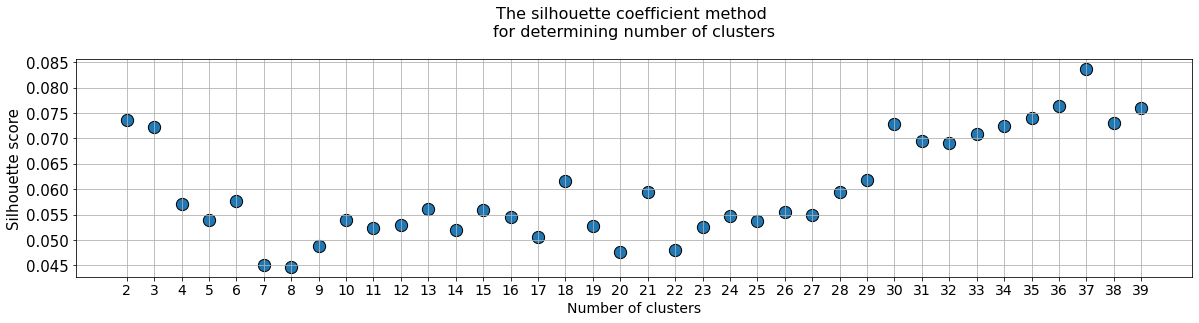

In [344]:
plt.figure(figsize=(20,4))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,40)],y=km_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,40)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

In [358]:
#count clusters
k = km_silhouette.index(max(km_silhouette)) + 2

37

In [345]:
#Initialize the class object
kmeans = KMeans(n_clusters=k, n_init=500)

#predict the labels of clusters.
label = kmeans.fit_predict(document_embeddings)
data_com['cluster'] = label

pca = PCA(2)
pca_df = pca.fit_transform(document_embeddings)

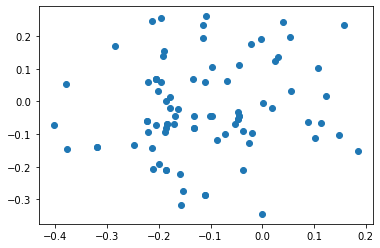

In [346]:
#filter rows of original data
filtered_label0 = pca_df[label == 0]

#plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1])
plt.show()

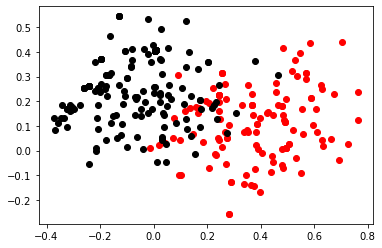

In [347]:
#filter rows of original data
filtered_label2 = pca_df[label == 2]

filtered_label8 = pca_df[label == 8]

#Plotting the results
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1] , color = 'red')
plt.scatter(filtered_label8[:,0] , filtered_label8[:,1] , color = 'black')
plt.show()

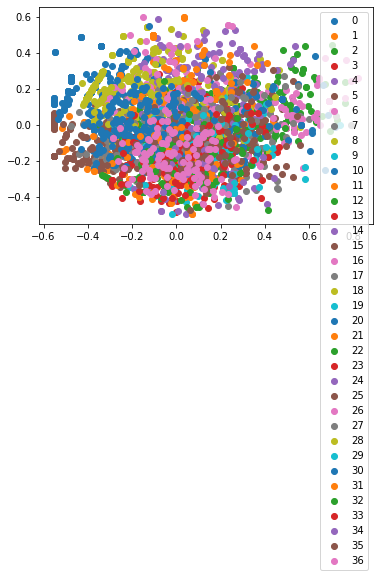

In [348]:
#Getting unique labels

u_labels = np.unique(label)

#plotting the results:

for i in u_labels:
    plt.scatter(pca_df[label == i , 0] , pca_df[label == i , 1] , label = i)
plt.legend()
plt.show()

In [349]:
data_com['cluster'] = label
data_com.groupby('cluster').Text.count()

cluster
0      84
1      44
2     126
3     109
4      69
5     219
6     101
7      82
8     163
9      56
10    154
11     47
12    101
13     51
14     96
15     87
16     94
17     92
18     40
19     37
20     77
21    112
22     39
23     88
24     51
25     69
26     53
27     61
28    142
29     45
30    175
31     73
32     73
33     62
34     17
35     48
36    122
Name: Text, dtype: int64

In [350]:
############# Не работает 
# cluster_centers = kmeans.cluster_centers_
# clusters_terms = pd.DataFrame({'Cluster' : [], 'Terms' : []})

# for i in range(len(cluster_centers)):
#   k_terms = [x[0] for x in model_w2v.wv.similar_by_vector(cluster_centers[i])[:3]]
#   mini_df = pd.DataFrame({'Cluster' : [i,i,i], 'Terms' : k_terms})
#   clusters_terms = pd.concat([clusters_terms, mini_df], ignore_index=True)

# clusters_terms

In [351]:
%%time
clusters_all = {}
for i in tqdm(range(k)):
    lab = document_embeddings[label==i]
    cluster_markers = Counter([model_w2v.similar_by_vector(x)[0] for x in lab])
    top = pd.DataFrame.from_dict(cluster_markers, orient='index').sort_values(by=0, ascending=False) \
                                      .reset_index().rename(columns={'index':'marker', 0:'count'}).head(4)
    clusters_all[i] = top.marker.tolist()

100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [01:08<00:00,  1.85s/it]

Wall time: 1min 8s


In [352]:
cluster_df = pd.DataFrame.from_dict(clusters_all, orient='index')
cluster_df['count'] = data_com.groupby('cluster').Text.count()
cluster_df.sort_values(by='count', ascending=True, inplace=True)
cluster_df

,0,1,2,3,count
34,"(кабинет_NOUN, 0.731246829032898)","(кабинет_NOUN, 0.7121080160140991)","(отметка::исх_NOUN, 0.6347477436065674)","(отметка::исх_NOUN, 0.624156653881073)",17
19,"(ошибка_NOUN, 0.8725041747093201)","(исполнительный_ADJ, 0.6490322351455688)","(бездействие_NOUN, 0.744885265827179)","(месяц_NOUN, 0.7931587100028992)",37
22,"(банкротство_NOUN, 1.0)","(зарплатный_ADJ, 0.8415271639823914)","(фз_NOUN, 0.8865081667900085)","(процедура_NOUN, 0.8600334525108337)",39
18,"(социальный_ADJ, 0.6920549869537354)","(пособие_NOUN, 0.7028075456619263)","(взыскание_NOUN, 0.6757331490516663)","(социальный_ADJ, 0.6694977283477783)",40
1,"(мочь_NOUN, 1.0)","(мочь_NOUN, 0.7631374597549438)","(мочь_NOUN, 0.7421882152557373)","(мочь_NOUN, 0.9155445098876953)",44
29,"(обращение_NOUN, 0.6186130046844482)","(обработка_NOUN, 0.6701231002807617)","(действие_NOUN, 0.7082824110984802)","(неправомерный_ADJ, 0.75297611951828)",45
11,"(операция_NOUN, 1.0)","(операция_NOUN, 0.9220597743988037)","(операция_NOUN, 0.8892995715141296)","(эмитироваться_VERB, 0.6771671772003174)",47
35,"(блокировка_NOUN, 1.0)","(блокировка_NOUN, 0.9104845523834229)","(возможность_NOUN, 0.8316368460655212)","(сбп_NOUN, 0.842010498046875)",48
13,"(отношение_NOUN, 0.8039674758911133)","(отвратительный_ADJ, 0.718652069568634)","(ужасный_ADJ, 0.6766344904899597)","(наплевательский_ADJ, 0.8113691806793213)",51
24,"(сотрудник_NOUN, 0.8786641955375671)","(некомпетентность_NOUN, 0.8609721064567566)","(действие_NOUN, 0.6698725819587708)","(инвалид_NOUN, 0.6990099549293518)",51


In [369]:
for i in data_com.query('cluster == 24').comment:
    print('-'*125)
    print(i)

-----------------------------------------------------------------------------------------------------------------------------
Являюсь постоянным клиентом Сбербанка уже кучу лет, понадобилось снять деньги со своего счета, дважды позвонила на 900, желая заказать деньги, ответили, что до 3 миллионов рублей заказать нельзя, что в Зеленограде, Савелкинский проезд, 6 большое хранилище и деньги обычно есть. Приехали в нужный день, денег не оказалось, я спросила, как так, ведь по 900 сказали, что заказать нельзя и не нужно, дважды, в разные дни, на что мне дословно сказали "не надо верить 900", вот это слова прям на слоган нужно, дальше они только подтвердились. посоветовали передать нужную сумму переводом, попытались перевести нужную сумму, платеж и Сбербанк онлайн мне заблокировали. Повторю, что деньги нужно было передать срочно. Вернулись в отделение, сказали, что могут принять заявление на разблокировку и рассматривать его будут 3 дня!!! Позвонила на 900, там пожимают плечами, ждите, вам п

In [ ]:
centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

for i  in range(k):
  print(f'CLUSTER {i}')
  for j in centroids[i, :3]:
    print(list(tokenizer.word_index.keys())[list(tokenizer.word_index.values()).index(j)])
  print('------------------------')


**ХЗ ЧТО ЭТО, НО ЖАЛЬ УДАЛЯТЬ**

In [ ]:
###### НАША МОДЕЛЬ #######

tagged_data = [TaggedDocument(words=word_tokenize(doc), tags=[i]) for i, doc in enumerate(data_com.Text)]
vector_size = 50
model_d2v = Doc2Vec(vector_size=vector_size, alpha=0.025, min_count=5)
  
model_d2v.build_vocab(tagged_data)
epochs = 30

for epoch in tqdm(range(epochs)):
    model_d2v.train(tagged_data,
            total_examples=model_d2v.corpus_count,
            epochs=model_d2v.epochs)
print(f'{epochs} epochs done!')    

document_embeddings=np.zeros((data_com.shape[0],vector_size))

for i in tqdm(range(len(document_embeddings))):
    document_embeddings[i]=model_d2v.docvecs[i]
    
    
pairwise_similarities=cosine_similarity(document_embeddings)
#pairwise_differences=euclidean_distances(document_embeddings)

# most_similar(0,pairwise_similarities,'Cosine Similarity')
#most_similar(0,pairwise_differences,'Euclidean Distance')

In [ ]:
clf = KMeans(n_clusters=5)
s = clf.fit(document_embeddings)
#print( s)

     # 20 центральные точки
print(clf.cluster_centers_)

     # Кластер, которому принадлежит каждый образец
print(clf.labels_)
i = 1
# while i <= len(clf.labels_):
#     #print( i, clf.labels_[i-1])
#     print(clf.labels_[i-1])
#     i = i + 1

In [ ]:
plt.figure(num=1, figsize=(20, 30), dpi=1200, facecolor='w', edgecolor='k')
text = ' '.join(data_com.Text.to_list())
stw = ('это', 'сбер', 'сбербанк', 'сбербанк онлайн', 'банк', 'быть', 'сам')
wd = wordcloud.WordCloud(background_color='white', colormap='Dark2', stopwords=stw).generate(text)


# Display the generated image:
plt.imshow(wd, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
plt.figure(figsize=(15,10), )
data_plot = data_com['Text']
data_plot['Text'] = data_com['Text'].value_counts()
data_plot.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel(data_plot["Text"])
plt.ylabel(data_plot['Text'].value_count())
plt.show()

In [ ]:
a = tfidf_vectors[0][0] * tokenizer.word_index[words[0]]
print(tokenizer.word_index[words[0]])
print(a.__str__())
print(tfidf_vectors[0][0].__str__())

In [ ]:
word = 'серый'
for k in ending_w2v:
  try:
    
    f=model_w2v[word+k]
    print('хехе', k)
    break
  except:
    print('не хехе', k)
    continue
print(f)

In [ ]:
d = data_com[data_com.negative == data_com.negative.cummax()].original_text
d = d.tolist()

In [ ]:
d